Saving D9g4_data1.xlsx to D9g4_data1.xlsx


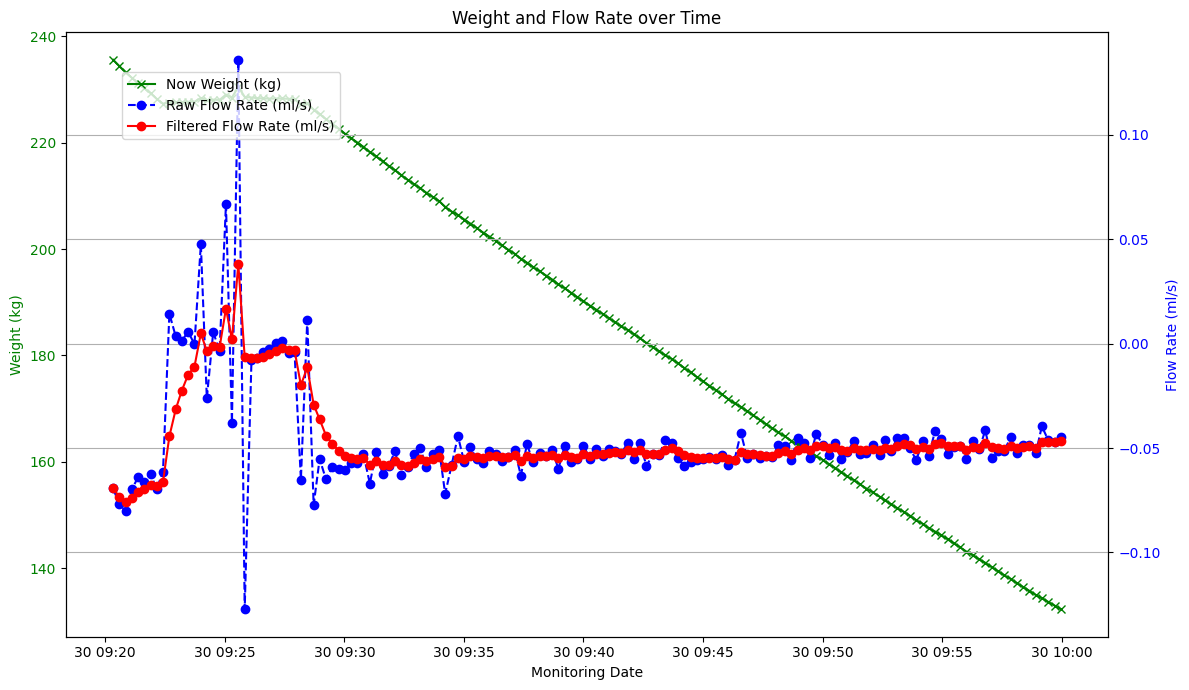

In [1]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt

# 파일 업로드
uploaded = files.upload()

# 업로드된 파일 이름 확인
file_name = list(uploaded.keys())[0]  # 업로드된 파일의 첫 번째 이름 가져오기

# 엑셀 파일 읽기 (파일명이 동적으로 설정)
df = pd.read_excel('D9g4_data1.xlsx')

# 데이터 검증
if 'monitoring_date' not in df.columns or 'now_weight' not in df.columns:
    raise ValueError("데이터에 'monitoring_date' 또는 'now_weight' 컬럼이 없습니다.")

# 'monitoring_date'를 datetime 형식으로 변환
df['monitoring_date'] = pd.to_datetime(df['monitoring_date'])

# 무게 변화 (now_weight)의 차이 계산
df['weight_change'] = df['now_weight'].diff()

# 유속 계산 (무게 변화 / 15초 간격)
df['flow_rate'] = df['weight_change'] / 15  # 15초 간격으로 측정

# NaN 값 처리 (첫 번째 row에서 diff로 인해 NaN 발생)
df = df.dropna()

# 칼만 필터 적용 함수
def kalman_filter(data, Q=0.1, R=1.0):
    n = len(data)
    x_est = [0] * n  # 필터링된 값 (결과)
    P = 1.0  # 오차 공분산
    for i in range(n):
        if i == 0:
            x_est[i] = data[i]  # 초기값 설정
        else:
            # 예측 단계
            P = P + Q

            # 칼만 이득 계산
            K = P / (P + R)

            # 추정값 업데이트
            x_est[i] = x_est[i - 1] + K * (data[i] - x_est[i - 1])

            # 오차 공분산 업데이트
            P = (1 - K) * P
    return x_est

# 칼만 필터를 유속 데이터에 적용
df['filtered_flow_rate'] = kalman_filter(df['flow_rate'].tolist())

# 두 그래프를 한 화면에 겹쳐서 그리기
fig, ax1 = plt.subplots(figsize=(12, 7))

# 첫 번째 그래프: 무게 변화
ax1.plot(df['monitoring_date'], df['now_weight'], label='Now Weight (kg)', color='green', marker='x')
ax1.set_xlabel('Monitoring Date')
ax1.set_ylabel('Weight (kg)', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_title('Weight and Flow Rate over Time')

# 두 번째 그래프: 필터링 전후 유속 변화
ax2 = ax1.twinx()  # x축을 공유하는 두 번째 y축 생성
ax2.plot(df['monitoring_date'], df['flow_rate'], label='Raw Flow Rate (ml/s)', color='blue', linestyle='--', marker='o')
ax2.plot(df['monitoring_date'], df['filtered_flow_rate'], label='Filtered Flow Rate (ml/s)', color='red', marker='o')
ax2.set_ylabel('Flow Rate (ml/s)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# 레이아웃 및 범례 설정
fig.tight_layout()  # 레이아웃 자동 조정
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))  # 범례 위치
plt.xticks(rotation=45)  # x축 날짜 라벨 회전
plt.grid(True)

# 그래프 출력
plt.show()
